<h1 id="title">Predicting Motor Vehicle Accident Severity in Seattle, Washington by Oversampling Minority Classes to Achieve Balanced Training Data<\h1>

In [1]:
# Import packages and modules.
import io
import itertools
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import pylab as pl
import scipy
import scipy.optimize as opt
import seaborn as sns
import sklearn
import sys
import timeit
import warnings
from matplotlib.ticker import NullFormatter
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.sparse import csr_matrix
from sklearn import linear_model
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree
from sklearn import utils
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.exceptions import ConvergenceWarning
from timeit import default_timer
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")

In [3]:
# Define the starting time for this notebook. 
notebook_start_time = default_timer()

In [4]:
# This function computes the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def elapsed_time(start_time = notebook_start_time):
    return default_timer() - start_time   

In [5]:
# This function prints the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def print_elapsed_time(start_time = notebook_start_time):
    print("Elapsed time is", elapsed_time(start_time), "seconds.")
    return None

In [6]:
# Create a list of display options.
list_of_display_options_fully_qualified_names = str(\
"pd.options.display.chop_threshold, pd.options.display.float_format, pd.options.display.max_info_columns, pd.options.display.notebook_repr_html, \
pd.options.display.colheader_justify, pd.options.display.html, pd.options.display.max_info_rows, pd.options.display.pprint_nest_depth, \
pd.options.display.column_space, pd.options.display.large_repr, pd.options.display.max_rows, pd.options.display.precision, \
pd.options.display.date_dayfirst, pd.options.display.latex, pd.options.display.max_seq_items, pd.options.display.show_dimensions, \
pd.options.display.date_yearfirst, pd.options.display.max_categories, pd.options.display.memory_usage, pd.options.display.unicode, \
pd.options.display.encoding, pd.options.display.max_columns, pd.options.display.min_rows, pd.options.display.width, \
pd.options.display.expand_frame_repr, pd.options.display.max_colwidth, pd.options.display.multi_sparse").split(sep=', ')

# Initialize an empty list to store all the short names for display options.
list_of_display_options_short_names = list()
# For each fully qualified option name,
# get the option's short name and add it to the list of short names.
for fully_qualified_option_name in list_of_display_options_fully_qualified_names:
    # Get short option name.
    short_option_name = fully_qualified_option_name.split(sep='.')[-1]
    
    # Add short option name to list of display option short names.
    list_of_display_options_short_names.append(short_option_name)

# Define dictionary of display option settings.
dict_of_display_option_settings_short_names=\
{"max_info_columns": 1000,\
"colheader_justify": "right",\
"max_info_rows": 1000000,\
"column_space": 1000,\
"max_rows": 1000000,\
"precision": 9,\
"max_seq_items": 1000000000000,\
"show_dimensions": True,\
"max_categories": 100,\
"memory_usage": True,\
"max_columns": 1000,\
"max_colwidth": 1000,\
"float_format": lambda x: '%.9f' % x}

# Set pandas display options using dictionary of short names,
# and display the options/value pairs.
print("Setting display options...")
for key in list(dict_of_display_option_settings_short_names.keys()):
    # Set display option.
    pd.set_option(key, dict_of_display_option_settings_short_names[key])
    # Print display option name and value.
    print(key, ": ", pd.get_option(key), sep='')

Setting display options...
max_info_columns: 1000
colheader_justify: right
max_info_rows: 1000000
column_space: 1000
max_rows: 1000000
precision: 9
max_seq_items: 1000000000000
show_dimensions: True
max_categories: 100
memory_usage: True
max_columns: 1000
max_colwidth: 1000
float_format: <function <lambda> at 0x7f179902b280>


In [7]:
# Set seed for random number generator.
# seed = np.int(os.times()[4]) # Use this line for better pseudo-random behavior.
seed = 42
print(seed)

42


In [8]:
# Attribute Information URL: https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf
# Read the Collisions Data CSV file and store it as a DataFrame.
# url="https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv" # HTTPError at 202009151050, using local copy of .csv instead.
# print(os.listdir("..")) # Print list of contents of current working directory.
local_path_to_csv = '~/IBM Data Science Professional Certificate Course/Course 9 - Applied Data Science Capstone/projects/Collisions.csv'
df=pd.read_csv(local_path_to_csv, low_memory=False)

In [9]:
# View the first few rows of the collisions DataFrame.
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.320757054,47.609407946,1,328476,329976,EA08706,Matched,Block,nan,BROADWAY BETWEEN E COLUMBIA ST AND BOYLSTON AVE,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2020/01/22 00:00:00+00,1/22/2020 3:21:00 PM,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,N,Raining,Wet,Dark - Street Lights On,NaN,nan,NaN,11,From same direction - both going straight - both moving - sideswipe,0,0,N
1,-122.319560827,47.662220664,2,328142,329642,EA06882,Matched,Block,nan,8TH AVE NE BETWEEN NE 45TH E ST AND NE 47TH ST,,NaN,1,Property Damage Only Collision,Parked Car,2,0,0,2,0,0,0,2020/01/07 00:00:00+00,1/7/2020 8:00:00 AM,Mid-Block (not related to intersection),15.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE",NaN,N,Clear,Dry,Daylight,NaN,nan,NaN,32,One parked--one moving,0,0,Y
2,-122.327524508,47.604393273,3,20700,20700,1181833,Unmatched,Block,nan,JAMES ST BETWEEN 6TH AVE AND 7TH AVE,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2004/01/30 00:00:00+00,1/30/2004,Mid-Block (but intersection related),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,4030032.000000000,NaN,NaN,NaN,0,0,N
3,-122.327524934,47.708621579,4,332126,333626,M16001640,Unmatched,Block,nan,NE NORTHGATE WAY BETWEEN 1ST AVE NE AND NE NORTHGATE DR,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2016/01/23 00:00:00+00,1/23/2016,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N
4,-122.292120049,47.559009080,5,328238,329738,3857118,Unmatched,Block,nan,M L KING JR ER WAY S BETWEEN S ANGELINE ST AND S EDMUNDS ST,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2020/01/26 00:00:00+00,1/26/2020,Mid-Block (not related to intersection),28.000000000,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221389 entries, 0 to 221388
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                213918 non-null  float64
 1   Y                213918 non-null  float64
 2   OBJECTID         221389 non-null  int64  
 3   INCKEY           221389 non-null  int64  
 4   COLDETKEY        221389 non-null  int64  
 5   REPORTNO         221389 non-null  object 
 6   STATUS           221389 non-null  object 
 7   ADDRTYPE         217677 non-null  object 
 8   INTKEY           71884 non-null   float64
 9   LOCATION         216801 non-null  object 
 10  EXCEPTRSNCODE    100986 non-null  object 
 11  EXCEPTRSNDESC    11779 non-null   object 
 12  SEVERITYCODE     221388 non-null  object 
 13  SEVERITYDESC     221389 non-null  object 
 14  COLLISIONTYPE    195159 non-null  object 
 15  PERSONCOUNT      221389 non-null  int64  
 16  PEDCOUNT         221389 non-null  int6

In [11]:
print_elapsed_time(notebook_start_time)

Elapsed time is 9.174134726985358 seconds.


<h2 id="data_wrangling">Data Wrangling</h2>

Steps for working with missing data:
<ol>
    <li>Identify missing data.</li>
    <li>Deal with missing data.</li>
    <li>Correct data format.</li>
</ol>

<h3 id="identifying_missing_data">Identifying Missing Data</h3>

The metadata document that accompanied the data set indicates that certain columns have "sentinel" values
that indicate an unknown or missing value. Each of these missing values will first be converted into NaN.
Subsequently, the NaN values will be dropped from the DataFrame.

In [12]:
# If any row of the collisions DataFrame contains a sentinel value representing "unknown",
# then replace it with NaN. 
# Sentinels for "unknown" are listed in the metadata document that accompanies the dataset.
df_unknowns_converted_to_nan = df.replace(to_replace=\
{"EXCEPTRSNCODE": " ",\
 "EXCEPTRSNDESC": "Not Enough Information, or Insufficient Location Information",\
 "SEVERITYCODE": "0",\
 "SEVERITYDESC": "Unknown",\
 "JUNCTIONTYPE": "Unknown",\
 "WEATHER": "Unknown",\
 "ROADCOND": "Unknown",\
 "LIGHTCOND": "Unknown",\
 "SDOT_COLCODE": float(0),\
 "SDOT_COLDESC": "NOT ENOUGH INFORMATION / NOT APPLICABLE",\
 "ST_COLCODE": " ",\
 "ST_COLDESC": "Not stated"},\
value=np.nan, inplace=False, limit=None, regex=False, method='pad')

df_unknowns_converted_to_nan.replace(to_replace={"ST_COLCODE": "0", }, value=np.nan, inplace=True, limit=None, regex=False, method='pad')

In [13]:
print_elapsed_time(notebook_start_time)

Elapsed time is 15.997757143923081 seconds.


<h3 id="deal_with_missing_data">Deal with Missing Data</h3>

<ol>
    <li>Drop the Data
        <ol>
            <li>Drop entire row.</li>
            <li>Drop entire column.</li>
        </ol>
    </li>
    <li>Replace the Data
        <ol>
            <li>Replace data by mean.</li>
            <li>Replace data by frequency.</li>
            <li>Replace data based on other functions.</li>
        </ol>
    </li>
        
</ol>

Whole columns should be dropped only if most entries in the column are empty.

In [14]:
print(list(df.columns))

['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR']


In [15]:
# Drop any column from the collisions DataFrame if it satisfies at least one of the following conditions:
# 1) more than 15% of the column's data is NaN;
# 2) the column only contains unique identification keys, or information not useful for model building;
# 3) the column's data is categorical but does not fit into a small (< 15) number of categories;
# 4) information in the column is redundant because it is already represented by another column;
# 5) it is not clear how to interpret the column's data.
list_of_columns_to_drop = ["ADDRTYPE",\
                           "STATUS",\
                           "OBJECTID",\
                           "INCKEY",\
                           "COLDETKEY",\
                           "REPORTNO",\
                           "INTKEY",\
                           "LOCATION",\
                           "EXCEPTRSNCODE",\
                           "EXCEPTRSNDESC",\
                           "SEVERITYDESC",\
                           "PERSONCOUNT",\
                           "INCDATE",\
                           "INCDTTM",\
                           "JUNCTIONTYPE",\
                           "SDOT_COLCODE",\
                           "SDOT_COLDESC",\
                           "INATTENTIONIND",\
                           "UNDERINFL",\
                           "PEDROWNOTGRNT",\
                           "SDOTCOLNUM",\
                           "SPEEDING",\
                           "ST_COLCODE",\
                           "ST_COLDESC",\
                           "SEGLANEKEY",\
                           "CROSSWALKKEY",\
                           "HITPARKEDCAR"]

In [16]:
# Drop the selected columns from the DataFrame after converting unknowns to NaN.
# Store the result in a new DataFrame.
df_drop_columns = df_unknowns_converted_to_nan.drop(columns=list_of_columns_to_drop, inplace=False)

In [17]:
# Drop any row that contains at least one NaN.
df_drop_columns_and_rows = df_drop_columns.dropna(axis="index", how="any", thresh=None, subset=None, inplace=False)

In [18]:
print_elapsed_time(notebook_start_time)

Elapsed time is 17.04383381002117 seconds.


<h3 id="correct_data_format">Correct Data Format</h3>

Ensure that each data type is appropriate for the corresponding feature.
Cast columns of type "object" as type "category", but leave all other column types unaltered.

In [19]:
# Create new DataFrame to store converted data types.
df_converted = pd.DataFrame()

for column in list(df_drop_columns_and_rows.columns):
    if (df_drop_columns_and_rows[column].dtype in [np.dtype('object')]):
        df_converted[column] = df_drop_columns_and_rows[column].astype('category')
    # Copy all other columns to new DataFrame without changing their types.
    else:
        df_converted[column] = df_drop_columns_and_rows[column]

In [20]:
# Create DataFrame of categorical or integer columns, inclusive.
df_categorical = df_converted.select_dtypes(include=["category", "integer"])

In [21]:
print_elapsed_time(notebook_start_time)

Elapsed time is 17.657812183955684 seconds.


<h2 id="feature_selection">Feature selection</h2>

#### Features before One-Hot Encoding

In [22]:
df_categorical.head()

,SEVERITYCODE,COLLISIONTYPE,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,WEATHER,ROADCOND,LIGHTCOND
0,1,Sideswipe,0,0,2,0,0,0,Raining,Wet,Dark - Street Lights On
1,1,Parked Car,0,0,2,0,0,0,Clear,Dry,Daylight
5,1,Rear Ended,0,0,2,0,0,0,Clear,Dry,Daylight
6,1,Other,0,0,1,0,0,0,Clear,Wet,Daylight
8,1,Sideswipe,0,0,2,0,0,0,Overcast,Dry,Daylight


In [23]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171872 entries, 0 to 221388
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   SEVERITYCODE     171872 non-null  category
 1   COLLISIONTYPE    171872 non-null  category
 2   PEDCOUNT         171872 non-null  int64   
 3   PEDCYLCOUNT      171872 non-null  int64   
 4   VEHCOUNT         171872 non-null  int64   
 5   INJURIES         171872 non-null  int64   
 6   SERIOUSINJURIES  171872 non-null  int64   
 7   FATALITIES       171872 non-null  int64   
 8   WEATHER          171872 non-null  category
 9   ROADCOND         171872 non-null  category
 10  LIGHTCOND        171872 non-null  category
dtypes: category(5), int64(6)
memory usage: 10.0 MB


In [24]:
print_elapsed_time(notebook_start_time)

Elapsed time is 18.02681706601288 seconds.


<h2 id="imbalanced_data">Dealing with Imbalanced Data</h2>

Because the data is imbalanced, we split the DataFrame into four DataFrames, one for each value of the SEVERITYCODE feature.

In [25]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
1    0.657943120
2    0.323036911
2b   0.017111571
3    0.001908397
Name: SEVERITYCODE, Length: 4, dtype: float64


In [26]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
2      55521
2b      2941
3        328
Name: SEVERITYCODE, Length: 4, dtype: int64


In [27]:
df_class_1 = df_categorical[df_categorical['SEVERITYCODE'] == '1']
df_class_2 = df_categorical[df_categorical['SEVERITYCODE'] == '2']
df_class_2b = df_categorical[df_categorical['SEVERITYCODE'] == '2b']
df_class_3 = df_categorical[df_categorical['SEVERITYCODE'] == '3']

In [28]:
print("SEVERITYCODE relative frequencies:")
print(df_class_1["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
3          0
2b         0
2          0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [29]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2     55521
3         0
2b        0
1         0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [30]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2b["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2b    2941
3        0
2        0
1        0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [31]:
print("SEVERITYCODE relative frequencies:")
print(df_class_3["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     328
2b      0
2       0
1       0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [32]:
# Store and print the size of the all classes.
class_1_size = len(df_class_1)
class_2_size = len(df_class_2)
class_2b_size = len(df_class_2b)
class_3_size = len(df_class_3)
print('class_1_size =', class_1_size)
print('class_2_size =', class_2_size)
print('class_2b_size =', class_2b_size)
print('class_3_size =', class_3_size)
print()
# Store and print the size of the minority class.
minority_class_size = len(df_class_3)
print('minority_class_size =', minority_class_size)

class_1_size = 113082
class_2_size = 55521
class_2b_size = 2941
class_3_size = 328

minority_class_size = 328


In [33]:
print_elapsed_time(notebook_start_time)

Elapsed time is 19.23640345095191 seconds.


<h2 id='sample_size_class_3'>Sample all Classes Equally to Create a Balanced Training Set<\h2>

In [34]:
# This parameter determines what fraction of the minority class's data are reserved for testing.
test_size_ratio = .5

# Using train/test splits, set aside part of the data for testing.
df_class_1_train_pre_sampling, df_class_1_test = train_test_split(df_class_1, test_size=test_size_ratio, random_state=seed)
df_class_2_train_pre_sampling, df_class_2_test = train_test_split(df_class_2, test_size=test_size_ratio, random_state=seed)
df_class_2b_train_pre_sampling, df_class_2b_test = train_test_split(df_class_2b, test_size=test_size_ratio, random_state=seed)
df_class_3_train_pre_sampling, df_class_3_test = train_test_split(df_class_3, test_size=test_size_ratio, random_state=seed)

In [35]:
# Build a balanced training set by sampling the pre_sampling training data equally:

# Set a sampling parameter to control the amount of oversampling for the minority class.
# Oversampling requires this parameter to be greater than 1.
# If this parameter is less than or equal to 1, then oversampling will not occur.
sampling_ratio = 8

# Set the replace parameter of the sample method based on the sampling ratio.
# If the sampling_ratio > 1, sample with replacement.
# Otherwise, sample without replacement.
sample_with_replacement = bool(sampling_ratio > 1)
# Print the value of the replace parameter before passing it to the sample method.
print('Sample class 3 with replacement: %s' % (sample_with_replacement))

# Sample the minority class's training set based on the sampling parameter and store the sample for later concatenation.
df_class_3_train = df_class_3_train_pre_sampling.sample(frac=sampling_ratio, replace=sample_with_replacement, axis='index', random_state=seed)

# Store the size of the minority class's training set.
class_3_train_size = df_class_3_train.shape[0]

# Take samples of the other classes' training data, where the sample size taken is equal to the size of the minority class's training set.
# If the sample size to be taken exceeds the number of samples in the class's training data, sample with replacement.

# Sampling for class 2b.
sample_with_replacement = bool(class_3_train_size > df_class_2b_train_pre_sampling.shape[0])
# Print the value of the replace parameter before passing it to the sample method.
print('Sample class 2b with replacement: %s' % (sample_with_replacement))
df_class_2b_train = df_class_2b_train_pre_sampling.sample(n=class_3_train_size, replace=sample_with_replacement, axis='index', random_state=seed)

# Sampling for class 2.
sample_with_replacement = bool(class_3_train_size > df_class_2_train_pre_sampling.shape[0])
# Print the value of the replace parameter before passing it to the sample method.
print('Sample class 2 with replacement: %s' % (sample_with_replacement))
df_class_2_train = df_class_2_train_pre_sampling.sample(n=class_3_train_size, replace=sample_with_replacement, axis='index', random_state=seed)

# Sampling for class 1.
sample_with_replacement = bool(class_3_train_size > df_class_1_train_pre_sampling.shape[0])
# Print the value of the replace parameter before passing it to the sample method.
print('Sample class 1 with replacement: %s' % (sample_with_replacement))
df_class_1_train = df_class_1_train_pre_sampling.sample(n=class_3_train_size, replace=sample_with_replacement, axis='index', random_state=seed)

Sample class 3 with replacement: True
Sample class 2b with replacement: False
Sample class 2 with replacement: False
Sample class 1 with replacement: False


In [36]:
# Make a balanced, unshuffled training set by concatenating the equal sized samples of the training sets for each class.
df_train_balanced_not_shuffled = pd.concat([df_class_1_train, df_class_2_train, df_class_2b_train, df_class_3_train], axis='index')

# Make a not necessarily balanced testing set by concatenating the testing sets for each class.
df_test_not_shuffled = pd.concat([df_class_1_test, df_class_2_test, df_class_2b_test, df_class_3_test], axis='index')

In [37]:
# Shuffle the training set and store it for tuning hyper-parameters and for cross-validation.
df_train = shuffle(df_train_balanced_not_shuffled, random_state=seed)

# Shuffle the unbalanced DataFrame and store it for validation and for comparing the models.
df_test = shuffle(df_test_not_shuffled, random_state=seed)

In [38]:
# Verify the training DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_train["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     1312
2b    1312
2     1312
1     1312
Name: SEVERITYCODE, Length: 4, dtype: int64


In [39]:
# Verify the new DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_train["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
3    0.250000000
2b   0.250000000
2    0.250000000
1    0.250000000
Name: SEVERITYCODE, Length: 4, dtype: float64


Let's define a feature set represented by the DataFrame X. 

In [40]:
X = df_train.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)

In [41]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5248 entries, 64781 to 147257
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   COLLISIONTYPE  5248 non-null   category
 1   PEDCOUNT       5248 non-null   int64   
 2   PEDCYLCOUNT    5248 non-null   int64   
 3   VEHCOUNT       5248 non-null   int64   
 4   WEATHER        5248 non-null   category
 5   ROADCOND       5248 non-null   category
 6   LIGHTCOND      5248 non-null   category
dtypes: category(4), int64(3)
memory usage: 186.0 KB


We also define the data for the target variable, SEVERITYCODE, by the array y:

In [42]:
y = df_train["SEVERITYCODE"].to_numpy()

In [43]:
print_elapsed_time(notebook_start_time)

Elapsed time is 20.580312027945183 seconds.


## Transform the Data 

We normalize the data by transforming it so that it is compatible
with the machine learning estimators we use in this notebook.
We use special care with sparse matrix data so as to not destroy the
structure.

In [44]:
# Create a OneHotEncoder and fit it to the features.
# The fit is performed on the data set before the any test/train splits.
# The data will be encoded as a sparse matrix, the default behavior.
start_time = default_timer()
print("Fitting OneHotEncoder to training data...")
encoder = OneHotEncoder(sparse=True, handle_unknown='error')
encoder.fit(df_categorical.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False))
#encoder.fit(X)
X = encoder.transform(X)
print("Completed in", elapsed_time(start_time), "seconds.")
# Display the categories of the encoder.
print(encoder.get_feature_names())

Fitting OneHotEncoder to training data...
Completed in 0.2202220200560987 seconds.
['x0_Angles' 'x0_Cycles' 'x0_Head On' 'x0_Left Turn' 'x0_Other'
 'x0_Parked Car' 'x0_Pedestrian' 'x0_Rear Ended' 'x0_Right Turn'
 'x0_Sideswipe' 'x1_0' 'x1_1' 'x1_2' 'x1_3' 'x1_4' 'x1_5' 'x1_6' 'x2_0'
 'x2_1' 'x2_2' 'x3_0' 'x3_1' 'x3_2' 'x3_3' 'x3_4' 'x3_5' 'x3_6' 'x3_7'
 'x3_8' 'x3_9' 'x3_10' 'x3_11' 'x3_12' 'x3_13' 'x3_14' 'x3_15'
 'x4_Blowing Sand/Dirt' 'x4_Clear' 'x4_Fog/Smog/Smoke' 'x4_Other'
 'x4_Overcast' 'x4_Partly Cloudy' 'x4_Raining' 'x4_Severe Crosswind'
 'x4_Sleet/Hail/Freezing Rain' 'x4_Snowing' 'x5_Dry' 'x5_Ice' 'x5_Oil'
 'x5_Other' 'x5_Sand/Mud/Dirt' 'x5_Snow/Slush' 'x5_Standing Water'
 'x5_Wet' 'x6_Dark - No Street Lights' 'x6_Dark - Street Lights Off'
 'x6_Dark - Street Lights On' 'x6_Dark - Unknown Lighting' 'x6_Dawn'
 'x6_Daylight' 'x6_Dusk' 'x6_Other']


In [45]:
type(X)

scipy.sparse.csr.csr_matrix

In [46]:
X.shape

(5248, 62)

In [47]:
y.shape

(5248,)

In [48]:
print_elapsed_time(notebook_start_time)

Elapsed time is 21.302592676016502 seconds.


<h2 id="logistic_regression">Building a Logistic Regression Model<\h2>

In [49]:
t0 = default_timer()
#kfold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
number_of_folds = 10
logistic_regression_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LogisticRegression(solver='saga', multi_class='auto', penalty='l1', max_iter=100, verbose=10, n_jobs=-1, random_state=seed), verbose=True)
scoring = ['f1_macro', 'f1_weighted', 'neg_log_loss', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
logistic_regression_scores = cross_validate(logistic_regression_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("Logistic regression score keys:", sorted(logistic_regression_scores.keys()))
print('Logistic Regression classifiers constructed in %f seconds.' % elapsed_time(t0))

Logistic regression score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_neg_log_loss', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
Logistic Regression classifiers constructed in 17.409153 seconds.


In [50]:
print_elapsed_time(notebook_start_time)

Elapsed time is 38.904235076974146 seconds.


<h2 id="support_vector_machine">Building a Support Vector Machine<\h2>

In [51]:
t0 = default_timer()
number_of_folds = 10
#kfold_cv = StratifiedKFold(n_splits=number_of_folds, shuffle=True, random_state=seed)
linear_svc_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LinearSVC(penalty='l1', dual=False, random_state=seed, max_iter=100), verbose=True)
scoring = ['f1_macro', 'f1_weighted', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
linear_svc_scores = cross_validate(linear_svc_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("Support Vector Machine score keys:", sorted(linear_svc_scores.keys()))
print('Support Vector Machine classifiers constructed in %f seconds.' % elapsed_time(t0))

Support Vector Machine score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
Support Vector Machine classifiers constructed in 2.116718 seconds.


In [52]:
print_elapsed_time(notebook_start_time)

Elapsed time is 41.15498074993957 seconds.


<h2 id="knn_classifier">Building a k-Nearsest Neighbors Classifier<\h2>

In [53]:
t0 = default_timer()
number_of_folds = 10

# Set maximum number of neighbors based on number of samples and number of folds to prevent errors.
maximum_number_of_neighbors = min(200, np.int((X.shape[0] * (1 - 1 / number_of_folds))) - 1) # Take the smaller of the two parameters for min().
k_neighbors_pipeline = make_pipeline(\
    StandardScaler(with_mean=False),\
    KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=-1, p=1, weights='distance'), verbose=True)

# Use only odd numbers of neighbors to avoid ties.
grid_parameters = {'kneighborsclassifier__n_neighbors': range(3, maximum_number_of_neighbors, 2)}
scoring = ['recall_weighted']
grid_search_cv = GridSearchCV(k_neighbors_pipeline, param_grid=grid_parameters,\
                              scoring=scoring, \
                              n_jobs=-1, refit='recall_weighted', cv=number_of_folds, verbose=50, pre_dispatch=2**10, error_score='raise',\
                              return_train_score=False)

grid_search_cv.fit(X, y)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  27 out of 990 | elapsed:  

GridSearchCV(cv=10, error_score='raise',
             estimator=Pipeline(steps=[('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_jobs=-1, p=1,
                                                             weights='distance'))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': range(3, 200, 2)},
             pre_dispatch=1024, refit='recall_weighted',
             scoring=['recall_weighted'], verbose=50)

In [54]:
print('Completed grid search in %f seconds' % (elapsed_time(t0)))

Completed grid search in 367.112021 seconds


In [55]:
# Store best KNeighborsClassifier from GridSearchCV and print its parameters.
k_neighbors_clf = grid_search_cv.best_estimator_
print('Best KNeighborsClassifier parameters:')
for key in k_neighbors_clf.get_params().keys():
    print(key, ':', k_neighbors_clf.get_params()[key])

Best KNeighborsClassifier parameters:
memory : None
steps : [('standardscaler', StandardScaler(with_mean=False)), ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1, n_neighbors=57, p=1, weights='distance'))]
verbose : True
standardscaler : StandardScaler(with_mean=False)
kneighborsclassifier : KNeighborsClassifier(n_jobs=-1, n_neighbors=57, p=1, weights='distance')
standardscaler__copy : True
standardscaler__with_mean : False
standardscaler__with_std : True
kneighborsclassifier__algorithm : auto
kneighborsclassifier__leaf_size : 30
kneighborsclassifier__metric : minkowski
kneighborsclassifier__metric_params : None
kneighborsclassifier__n_jobs : -1
kneighborsclassifier__n_neighbors : 57
kneighborsclassifier__p : 1
kneighborsclassifier__weights : distance


In [56]:
t0 = default_timer()
number_of_folds = 10
#kfold_cv = StratifiedKFold(n_splits=number_of_folds, shuffle=True, random_state=seed)
scoring = ['f1_macro', 'f1_weighted', 'neg_log_loss', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
k_neighbors_scores = cross_validate(k_neighbors_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("k-Neighbors score keys:", sorted(k_neighbors_scores.keys()))
print('k-Neighbors Classifiers constructed in %f seconds.' % elapsed_time(t0))

k-Neighbors score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_neg_log_loss', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
k-Neighbors Classifiers constructed in 7.187484 seconds.


In [57]:
print_elapsed_time(notebook_start_time)

Elapsed time is 415.80713614996057 seconds.


## Test the Models and Compare their Performance

In [58]:
# Set starting time for reports and graphics.
t0 = default_timer()

In [59]:
#df_categorical.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85937 entries, 184164 to 109788
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   SEVERITYCODE     85937 non-null  category
 1   COLLISIONTYPE    85937 non-null  category
 2   PEDCOUNT         85937 non-null  int64   
 3   PEDCYLCOUNT      85937 non-null  int64   
 4   VEHCOUNT         85937 non-null  int64   
 5   INJURIES         85937 non-null  int64   
 6   SERIOUSINJURIES  85937 non-null  int64   
 7   FATALITIES       85937 non-null  int64   
 8   WEATHER          85937 non-null  category
 9   ROADCOND         85937 non-null  category
 10  LIGHTCOND        85937 non-null  category
dtypes: category(5), int64(6)
memory usage: 5.0 MB


In [60]:
# Print the relative frequencies for the validation DataFrame.
print("SEVERITYCODE relative frequencies:")
print(df_test["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     56541
2     27761
2b     1471
3       164
Name: SEVERITYCODE, Length: 4, dtype: int64


In [61]:
# Print the relative frequencies for the validation DataFrame.
print("SEVERITYCODE relative frequencies:")
print(df_test["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
1    0.657935464
2    0.323038970
2b   0.017117191
3    0.001908375
Name: SEVERITYCODE, Length: 4, dtype: float64


In [62]:
# Encode the data using the OneHotEncoder fitted before the models were created.
start_time = default_timer()
# print("Transforming full data set's feature set using OneHotEncoder...")
# X = df_categorical.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)
# X = encoder.transform(X)
print('Transforming features using OneHotEncoder...')
X_test = df_test.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)
X_test = encoder.transform(X_test)
print("Encoding completed in", elapsed_time(start_time), "seconds.")

Transforming features using OneHotEncoder...
Encoding completed in 0.3281505850609392 seconds.


In [63]:
y_test = df_test['SEVERITYCODE'].to_numpy()

In [64]:
X_test.shape

(85937, 62)

In [65]:
y_test.shape

(85937,)

In [66]:
print_elapsed_time(notebook_start_time)

Elapsed time is 417.05853932595346 seconds.


In [67]:
# Report statistics of the models built for each fold of the cross-validation.
print('Logistic Regression Cross-validation Scores:')
print()
for key in sorted(logistic_regression_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(logistic_regression_scores[key]), np.std(logistic_regression_scores[key])), sep='')
        print('%s :%s' % (key, logistic_regression_scores[key]), sep='')
        print()

Logistic Regression Cross-validation Scores:

fit_time: mean = 2.711377, std = 0.065995
fit_time :[2.8237474  2.71343088 2.69688201 2.70289087 2.70345569 2.77514386
 2.72348857 2.64757848 2.75771403 2.56943512]

score_time: mean = 0.086901, std = 0.007426
score_time :[0.0863564  0.09885335 0.09602141 0.09370589 0.07881212 0.07765079
 0.09214354 0.08102655 0.08553267 0.07890511]

test_f1_macro: mean = 0.473676, std = 0.015183
test_f1_macro :[0.4576477  0.49076116 0.4819635  0.47025032 0.47734848 0.4762067
 0.44695839 0.47111173 0.50211026 0.46239816]

test_f1_weighted: mean = 0.473680, std = 0.015280
test_f1_weighted :[0.45760201 0.49075862 0.48217702 0.47055954 0.47753001 0.47632968
 0.44653464 0.47079901 0.50211026 0.46239816]

test_neg_log_loss: mean = -1.127769, std = 0.021561
test_neg_log_loss :[-1.14498389 -1.11307522 -1.14339156 -1.12379309 -1.09699111 -1.16194929
 -1.12326994 -1.13121527 -1.09128953 -1.14772613]

test_precision_macro: mean = 0.499802, std = 0.017742
test_precisi

Logistic Regression Model 1 of 10:

              precision    recall  f1-score   support

           1   0.867622  0.486160  0.623148     56541
           2   0.407805  0.579338  0.478668     27761
          2b   0.063018  0.212101  0.097166      1471
           3   0.009629  0.579268  0.018943       164

    accuracy                       0.511747     85937
   macro avg   0.337018  0.464217  0.304481     85937
weighted avg   0.703673  0.511747  0.566319     85937



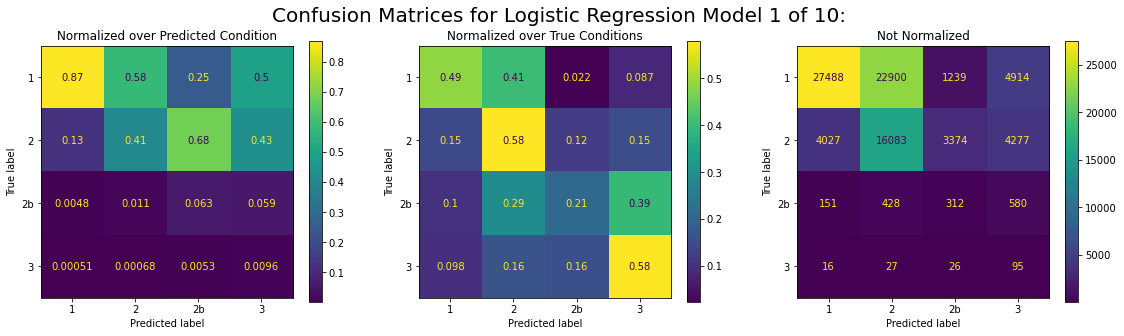

Logistic Regression Model 2 of 10:

              precision    recall  f1-score   support

           1   0.866692  0.487080  0.623662     56541
           2   0.407627  0.573683  0.476605     27761
          2b   0.063323  0.222298  0.098568      1471
           3   0.009066  0.548780  0.017838       164

    accuracy                       0.510642     85937
   macro avg   0.336677  0.457960  0.304168     85937
weighted avg   0.703008  0.510642  0.566013     85937



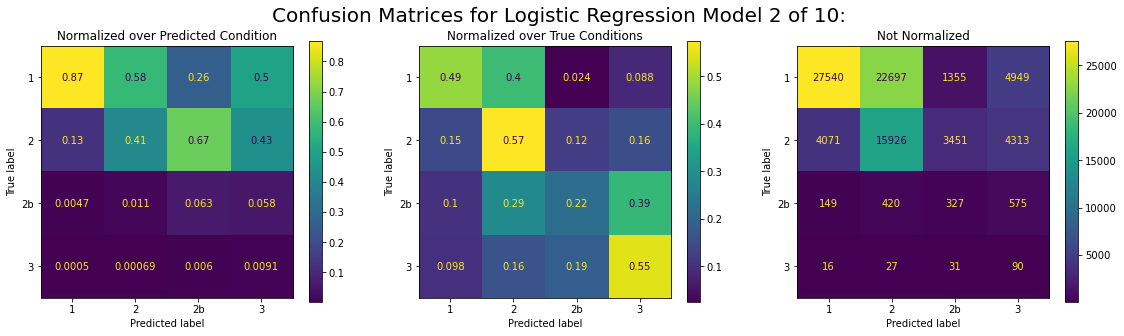

Logistic Regression Model 3 of 10:

              precision    recall  f1-score   support

           1   0.866014  0.488124  0.624341     56541
           2   0.409068  0.562228  0.473572     27761
          2b   0.056540  0.225697  0.090426      1471
           3   0.009362  0.573171  0.018422       164

    accuracy                       0.507732     85937
   macro avg   0.335246  0.462305  0.301691     85937
weighted avg   0.702912  0.507732  0.565342     85937



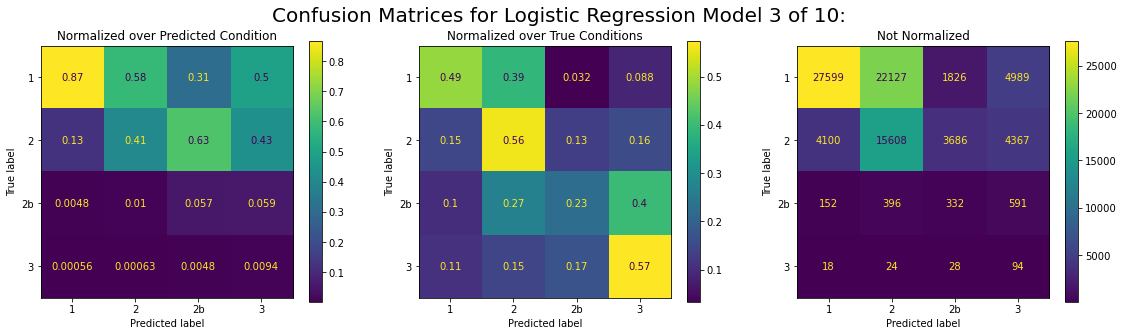

Logistic Regression Model 4 of 10:

              precision    recall  f1-score   support

           1   0.866791  0.486691  0.623369     56541
           2   0.408862  0.562047  0.473370     27761
          2b   0.057228  0.233855  0.091954      1471
           3   0.009085  0.554878  0.017876       164

    accuracy                       0.506836     85937
   macro avg   0.335491  0.459368  0.301642     85937
weighted avg   0.703368  0.506836  0.564662     85937



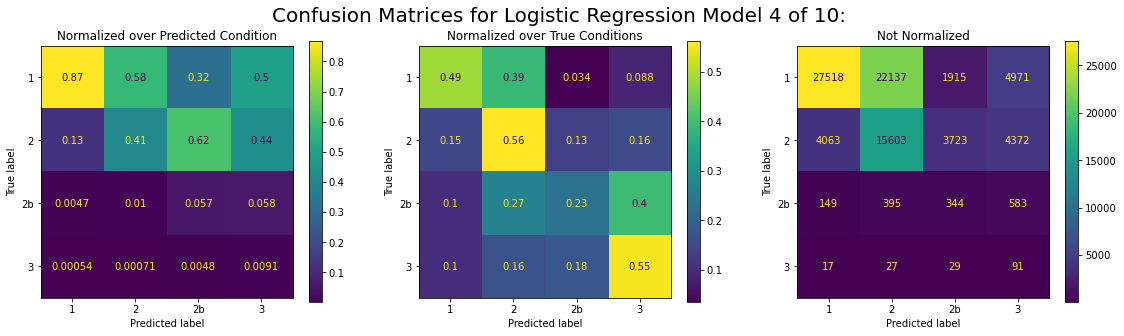

Logistic Regression Model 5 of 10:

              precision    recall  f1-score   support

           1   0.866327  0.487381  0.623814     56541
           2   0.407626  0.573755  0.476629     27761
          2b   0.063987  0.217539  0.098888      1471
           3   0.009053  0.554878  0.017815       164

    accuracy                       0.510793     85937
   macro avg   0.336748  0.458388  0.304287     85937
weighted avg   0.702779  0.510793  0.566126     85937



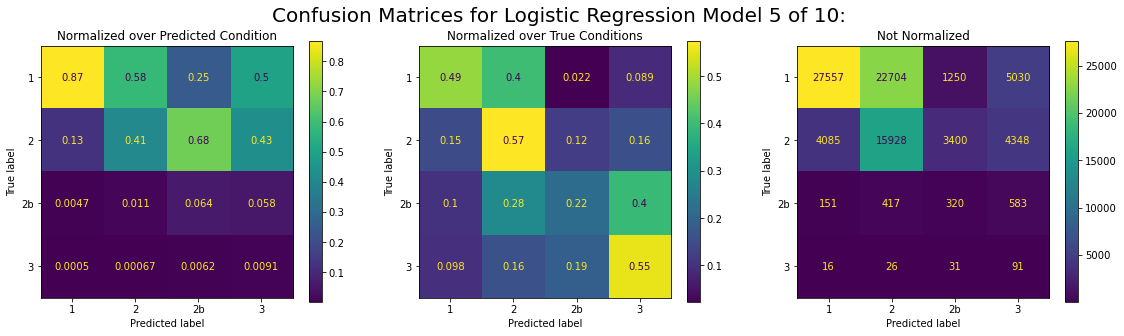

Logistic Regression Model 6 of 10:

              precision    recall  f1-score   support

           1   0.867634  0.485400  0.622526     56541
           2   0.407446  0.574367  0.476717     27761
          2b   0.064300  0.221618  0.099679      1471
           3   0.009207  0.567073  0.018120       164

    accuracy                       0.509780     85937
   macro avg   0.337147  0.462115  0.304261     85937
weighted avg   0.703586  0.509780  0.565321     85937



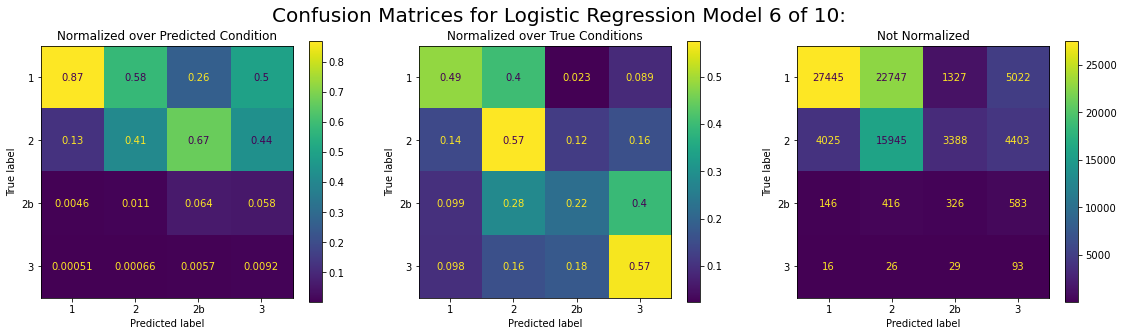

Logistic Regression Model 7 of 10:

              precision    recall  f1-score   support

           1   0.870113  0.482216  0.620533     56541
           2   0.407813  0.580599  0.479104     27761
          2b   0.063620  0.219579  0.098656      1471
           3   0.009398  0.573171  0.018493       164

    accuracy                       0.509676     85937
   macro avg   0.337736  0.463891  0.304197     85937
weighted avg   0.705325  0.509676  0.564764     85937



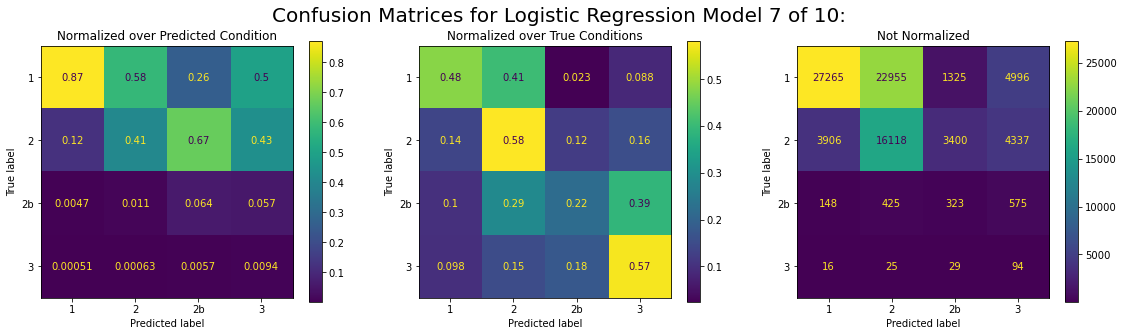

Logistic Regression Model 8 of 10:

              precision    recall  f1-score   support

           1   0.867652  0.483967  0.621351     56541
           2   0.408311  0.563128  0.473383     27761
          2b   0.056685  0.233175  0.091199      1471
           3   0.009442  0.579268  0.018582       164

    accuracy                       0.505428     85937
   macro avg   0.335522  0.464885  0.301129     85937
weighted avg   0.703747  0.505428  0.563327     85937



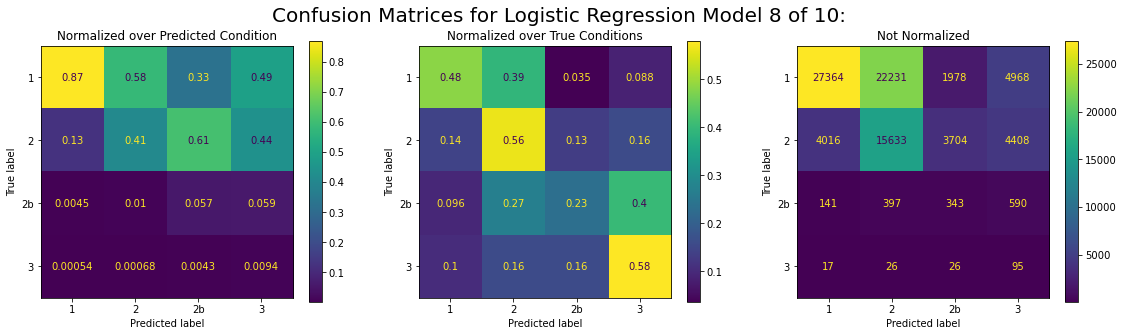

Logistic Regression Model 9 of 10:

              precision    recall  f1-score   support

           1   0.866472  0.487186  0.623692     56541
           2   0.408002  0.570477  0.475750     27761
          2b   0.062572  0.221618  0.097590      1471
           3   0.009190  0.567073  0.018086       164

    accuracy                       0.509699     85937
   macro avg   0.336559  0.461588  0.303780     85937
weighted avg   0.702972  0.509699  0.565740     85937



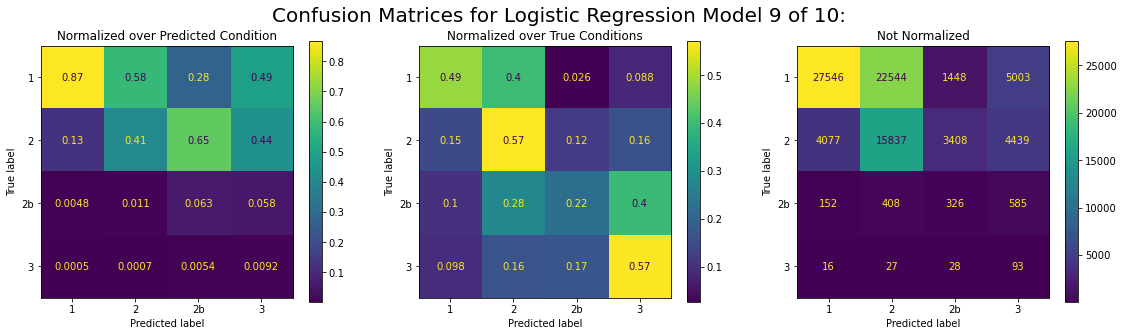

Logistic Regression Model 10 of 10:

              precision    recall  f1-score   support

           1   0.870346  0.481668  0.620138     56541
           2   0.407116  0.578257  0.477825     27761
          2b   0.062714  0.212101  0.096804      1471
           3   0.009668  0.603659  0.019031       164

    accuracy                       0.508489     85937
   macro avg   0.337461  0.468921  0.303450     85937
weighted avg   0.705238  0.508489  0.564060     85937



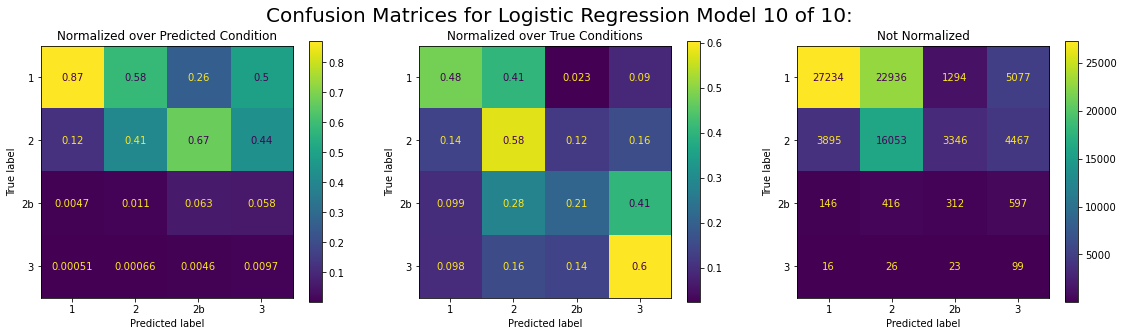

In [68]:
# For each logistic regression classifier in the cross-validation, print the macro recall, score report, and confusion matrices.
number_of_models = len(logistic_regression_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, logistic_regression_clf in zip(range(len(logistic_regression_scores['estimator'])), logistic_regression_scores['estimator']):
    y_test_predicted = logistic_regression_clf.predict(X_test)
    print('Logistic Regression Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for Logistic Regression Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1, 3, 1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1, 3, 2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1, 3, 3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)

    plt.show()

In [69]:
print_elapsed_time(notebook_start_time)

Elapsed time is 555.4535510729766 seconds.


In [70]:
# Report statistics of the models built for each fold of the cross-validation.
print('Support Vector Machine Cross-validation Scores:')
print()
for key in sorted(linear_svc_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(linear_svc_scores[key]), np.std(linear_svc_scores[key])), sep='')
        print('%s :%s' % (key, linear_svc_scores[key]), sep='')
        print()

Support Vector Machine Cross-validation Scores:

fit_time: mean = 0.307133, std = 0.035134
fit_time :[0.28299308 0.29312444 0.26925921 0.28472328 0.3566153  0.28676796
 0.28857064 0.30761218 0.3147614  0.38689756]

score_time: mean = 0.083118, std = 0.026272
score_time :[0.07408881 0.07652926 0.16010833 0.07341242 0.07574797 0.06937218
 0.0881424  0.07294726 0.07593513 0.06489801]

test_f1_macro: mean = 0.464217, std = 0.016393
test_f1_macro :[0.44641571 0.47456919 0.47852072 0.4577848  0.48147324 0.45484242
 0.44318888 0.46636482 0.49326394 0.44574546]

test_f1_weighted: mean = 0.464215, std = 0.016470
test_f1_weighted :[0.44640519 0.47461193 0.47873534 0.45806618 0.48163275 0.45497856
 0.44272148 0.46599131 0.49326394 0.44574546]

test_precision_macro: mean = 0.500258, std = 0.020095
test_precision_macro :[0.49936073 0.51327424 0.51257116 0.49313218 0.51775771 0.4941348
 0.47020253 0.5095071  0.53024659 0.46239659]

test_precision_weighted: mean = 0.500242, std = 0.020127
test_precis

Support Vector Machine Model 1 of 10:

              precision    recall  f1-score   support

           1   0.872738  0.475213  0.615358     56541
           2   0.407795  0.585318  0.480690     27761
          2b   0.061317  0.165194  0.089437      1471
           3   0.008906  0.615854  0.017558       164

    accuracy                       0.505743     85937
   macro avg   0.337689  0.460394  0.300761     85937
weighted avg   0.707006  0.505743  0.561712     85937



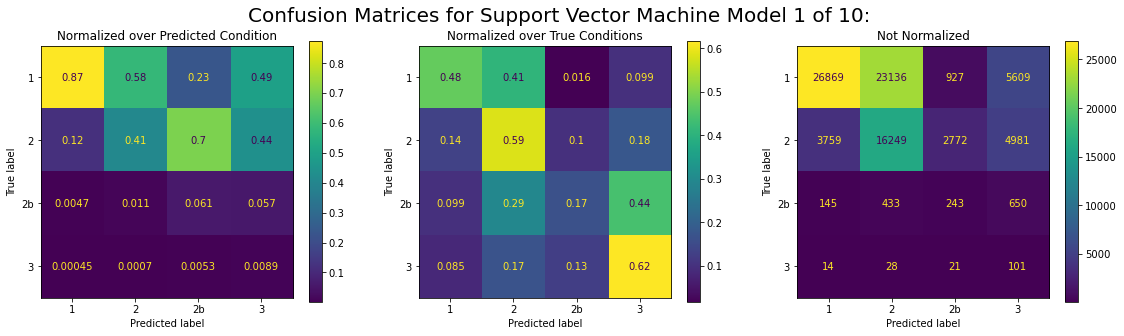

Support Vector Machine Model 2 of 10:

              precision    recall  f1-score   support

           1   0.868776  0.480784  0.619007     56541
           2   0.407936  0.582904  0.479972     27761
          2b   0.058226  0.175391  0.087428      1471
           3   0.009101  0.585366  0.017924       164

    accuracy                       0.508745     85937
   macro avg   0.336010  0.456111  0.301083     85937
weighted avg   0.704392  0.508745  0.563847     85937



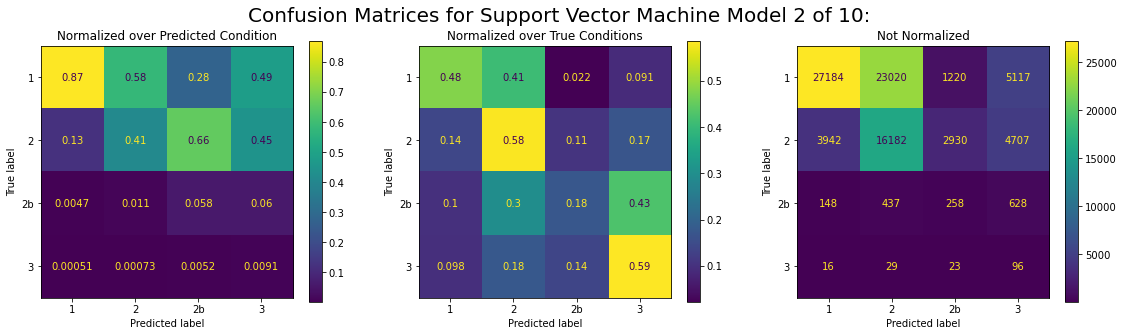

Support Vector Machine Model 3 of 10:

              precision    recall  f1-score   support

           1   0.866846  0.485541  0.622439     56541
           2   0.408331  0.580527  0.479436     27761
          2b   0.061574  0.161115  0.089098      1471
           3   0.009406  0.628049  0.018535       164

    accuracy                       0.510944     85937
   macro avg   0.336539  0.463808  0.302377     85937
weighted avg   0.703307  0.510944  0.565962     85937



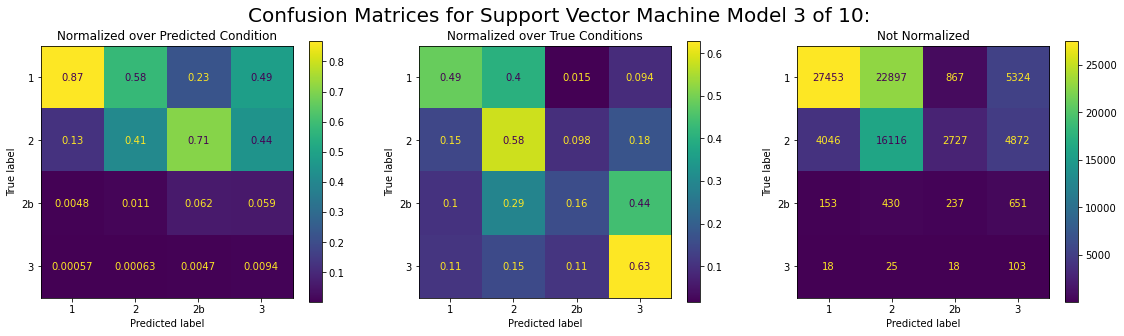

Support Vector Machine Model 4 of 10:

              precision    recall  f1-score   support

           1   0.872131  0.475160  0.615163     56541
           2   0.407775  0.581895  0.479518     27761
          2b   0.064743  0.181509  0.095442      1471
           3   0.008953  0.621951  0.017652       164

    accuracy                       0.504893     85937
   macro avg   0.338400  0.465129  0.301944     85937
weighted avg   0.706658  0.504893  0.561308     85937



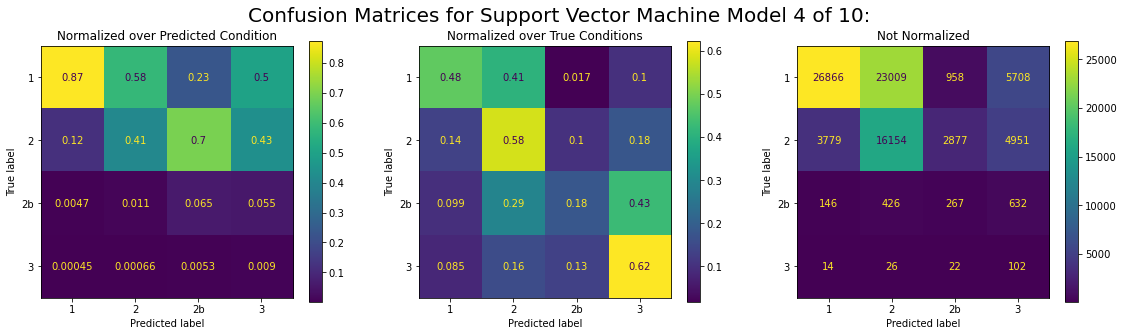

Support Vector Machine Model 5 of 10:

              precision    recall  f1-score   support

           1   0.872524  0.475142  0.615245     56541
           2   0.407843  0.585534  0.480796     27761
          2b   0.066124  0.171312  0.095418      1471
           3   0.008885  0.621951  0.017520       164

    accuracy                       0.505882     85937
   macro avg   0.338844  0.463485  0.302245     85937
weighted avg   0.706962  0.505882  0.561774     85937



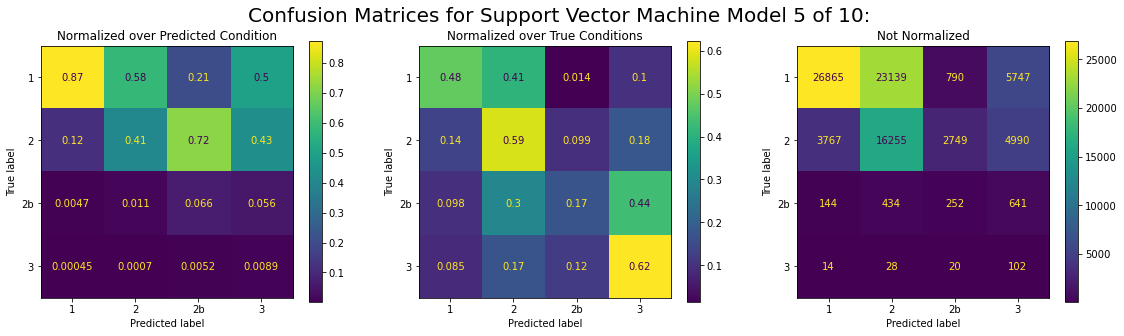

Support Vector Machine Model 6 of 10:

              precision    recall  f1-score   support

           1   0.872728  0.472259  0.612874     56541
           2   0.408064  0.583336  0.480206     27761
          2b   0.062213  0.184228  0.093015      1471
           3   0.009027  0.621951  0.017795       164

    accuracy                       0.503497     85937
   macro avg   0.338008  0.465444  0.300973     85937
weighted avg   0.707102  0.503497  0.559983     85937



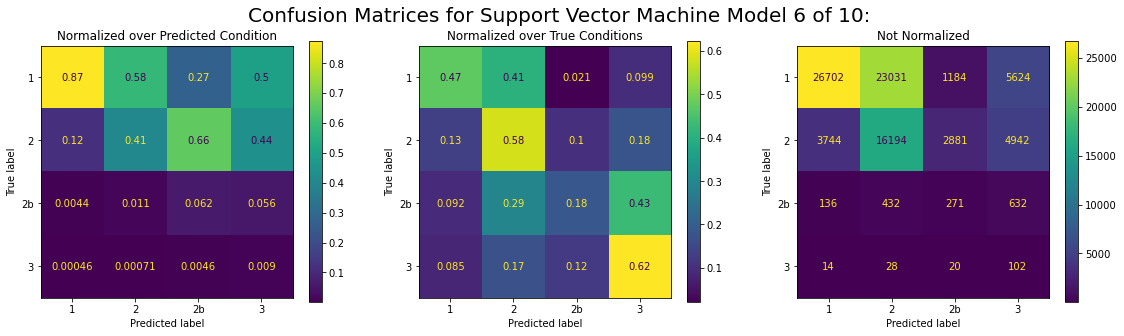

Support Vector Machine Model 7 of 10:

              precision    recall  f1-score   support

           1   0.873676  0.473992  0.614566     56541
           2   0.407941  0.585894  0.480985     27761
          2b   0.066616  0.178790  0.097066      1471
           3   0.009001  0.628049  0.017748       164

    accuracy                       0.505382     85937
   macro avg   0.339308  0.466681  0.302591     85937
weighted avg   0.707760  0.505382  0.561417     85937



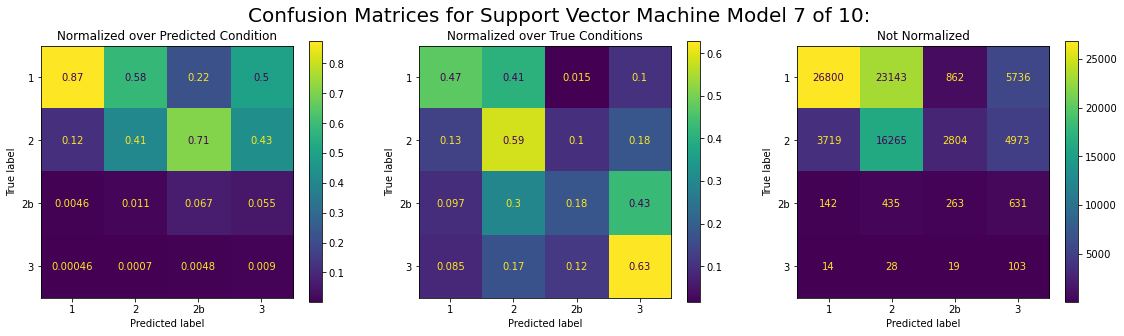

Support Vector Machine Model 8 of 10:

              precision    recall  f1-score   support

           1   0.873244  0.471534  0.612390     56541
           2   0.407332  0.582364  0.479370     27761
          2b   0.061406  0.183549  0.092025      1471
           3   0.009011  0.621951  0.017765       164

    accuracy                       0.502694     85937
   macro avg   0.337748  0.464849  0.300387     85937
weighted avg   0.707190  0.502694  0.559377     85937



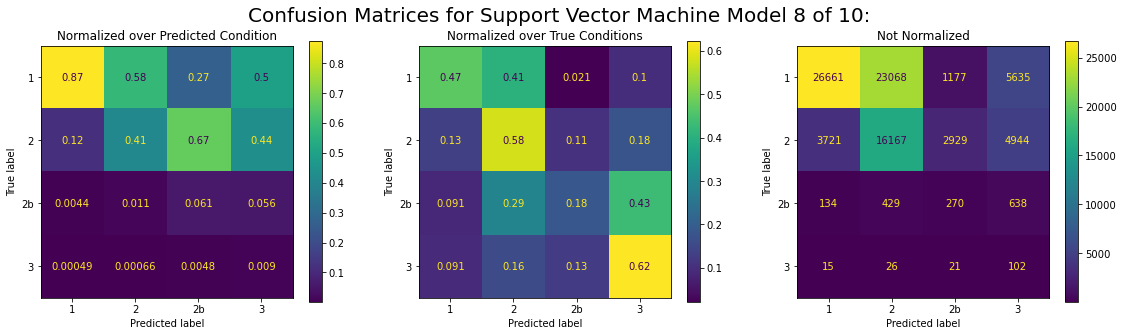

Support Vector Machine Model 9 of 10:

              precision    recall  f1-score   support

           1   0.873301  0.472630  0.613328     56541
           2   0.407940  0.577033  0.477972     27761
          2b   0.057030  0.186948  0.087399      1471
           3   0.008625  0.591463  0.017001       164

    accuracy                       0.501693     85937
   macro avg   0.336724  0.457019  0.298925     85937
weighted avg   0.707349  0.501693  0.559462     85937



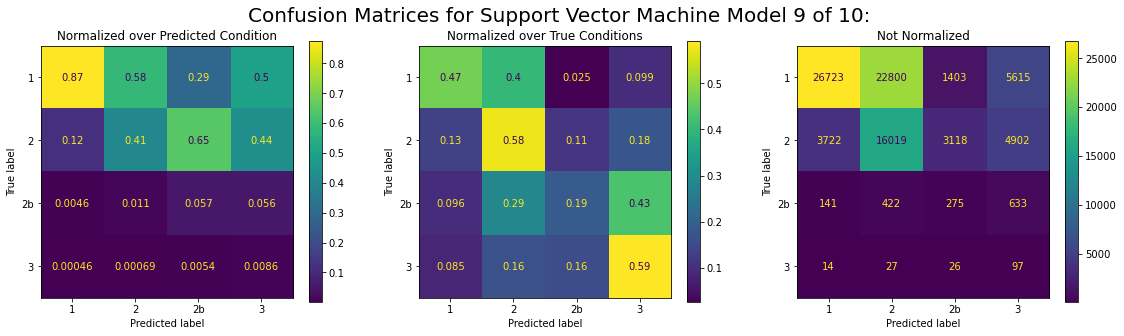

Support Vector Machine Model 10 of 10:

              precision    recall  f1-score   support

           1   0.873479  0.473515  0.614116     56541
           2   0.407768  0.585822  0.480841     27761
          2b   0.059869  0.167233  0.088172      1471
           3   0.009297  0.640244  0.018328       164

    accuracy                       0.504870     85937
   macro avg   0.337603  0.466703  0.300364     85937
weighted avg   0.707460  0.504870  0.560923     85937



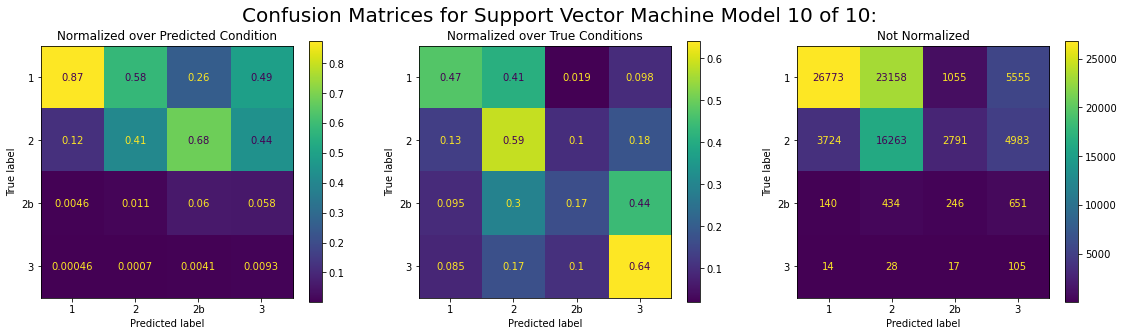

In [71]:
# For each support vector machine classifier in the cross-validation, print the score report and confusion matrices.
number_of_models = len(linear_svc_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, linear_svc_clf in zip(range(len(linear_svc_scores['estimator'])), linear_svc_scores['estimator']):
    y_test_predicted = linear_svc_clf.predict(X_test)
    print('Support Vector Machine Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for Support Vector Machine Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1,3,1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1,3,2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1,3,3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)
    
    plt.show()

In [72]:
print_elapsed_time(notebook_start_time)

Elapsed time is 692.1585659739794 seconds.


In [73]:
# Report statistics of the models built for each fold of the cross-validation.
print('k-Nearest Neighbors Cross-validation Scores:')
print()
for key in sorted(k_neighbors_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(k_neighbors_scores[key]), np.std(k_neighbors_scores[key])), sep='')
        print('%s :%s' % (key, k_neighbors_scores[key]), sep='')
        print()

k-Nearest Neighbors Cross-validation Scores:

fit_time: mean = 0.035850, std = 0.007682
fit_time :[0.03737974 0.03159738 0.04286909 0.02605247 0.04011393 0.02626276
 0.052917   0.03315377 0.0318954  0.03625512]

score_time: mean = 1.372616, std = 0.022824
score_time :[1.40162754 1.36836123 1.40591979 1.38590789 1.32978058 1.34348011
 1.36002302 1.36660671 1.38164163 1.38280964]

test_f1_macro: mean = 0.481837, std = 0.017476
test_f1_macro :[0.4818648  0.48047967 0.50869145 0.49619943 0.48988309 0.48035525
 0.43691209 0.47630123 0.48313758 0.48454796]

test_f1_weighted: mean = 0.481833, std = 0.017671
test_f1_weighted :[0.48162775 0.48045773 0.50895642 0.49652413 0.49009423 0.48050341
 0.43648951 0.47599287 0.48313758 0.48454796]

test_neg_log_loss: mean = -1.993263, std = 0.202655
test_neg_log_loss :[-1.86565163 -1.71158967 -1.90591304 -2.06470601 -1.8743476  -2.45446607
 -1.83037711 -2.21342967 -2.01470542 -1.99744445]

test_precision_macro: mean = 0.494000, std = 0.021762
test_precis

k-Nearest Neighbor Model 1 of 10:

              precision    recall  f1-score   support

           1   0.798276  0.556835  0.656047     56541
           2   0.393729  0.441483  0.416241     27761
          2b   0.063784  0.221618  0.099058      1471
           3   0.007409  0.463415  0.014585       164

    accuracy                       0.513655     85937
   macro avg   0.315799  0.420838  0.296482     85937
weighted avg   0.653510  0.513655  0.567822     85937



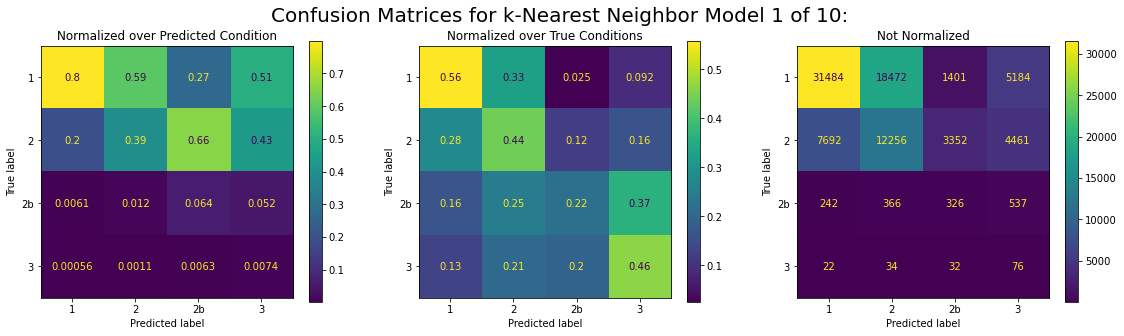

k-Nearest Neighbor Model 2 of 10:

              precision    recall  f1-score   support

           1   0.824990  0.527829  0.643772     56541
           2   0.403480  0.471093  0.434673     27761
          2b   0.050422  0.271924  0.085070      1471
           3   0.007434  0.426829  0.014614       164

    accuracy                       0.504928     85937
   macro avg   0.321582  0.424419  0.294532     85937
weighted avg   0.674007  0.504928  0.565461     85937



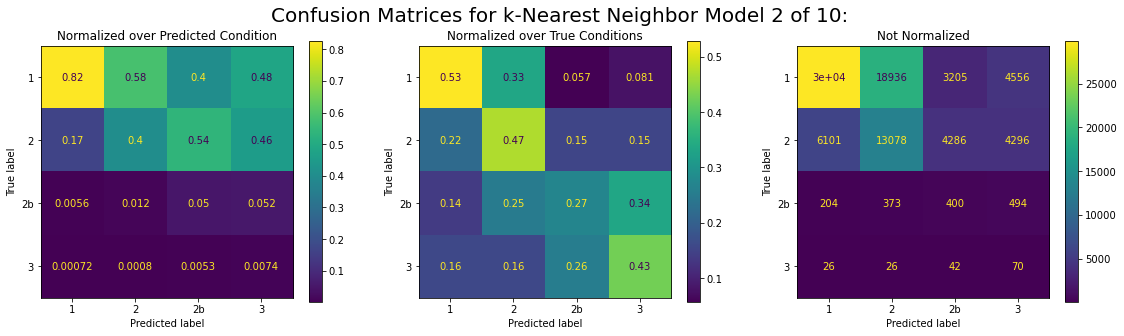

k-Nearest Neighbor Model 3 of 10:

              precision    recall  f1-score   support

           1   0.826419  0.524929  0.642042     56541
           2   0.402221  0.485357  0.439896     27761
          2b   0.053819  0.197825  0.084618      1471
           3   0.007286  0.493902  0.014360       164

    accuracy                       0.506487     85937
   macro avg   0.322436  0.425503  0.295229     85937
weighted avg   0.674598  0.506487  0.566001     85937



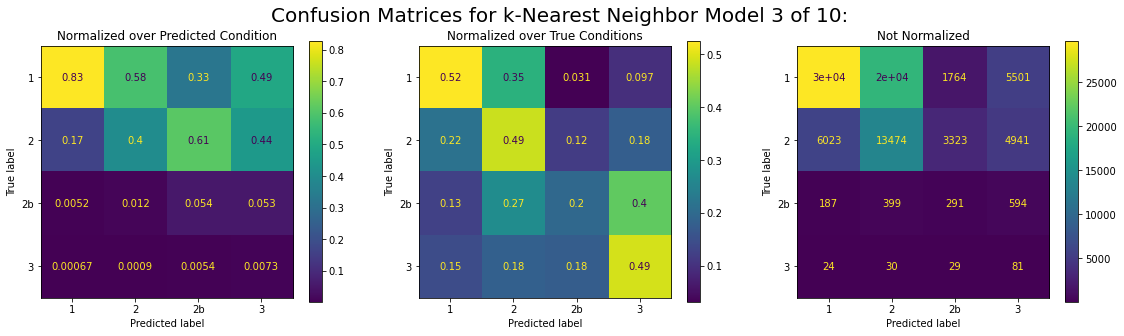

k-Nearest Neighbor Model 4 of 10:

              precision    recall  f1-score   support

           1   0.832431  0.503086  0.627150     56541
           2   0.393479  0.504305  0.442052     27761
          2b   0.057585  0.252889  0.093809      1471
           3   0.007814  0.463415  0.015369       164

    accuracy                       0.499121     85937
   macro avg   0.322827  0.430924  0.294595     85937
weighted avg   0.675796  0.499121  0.557059     85937



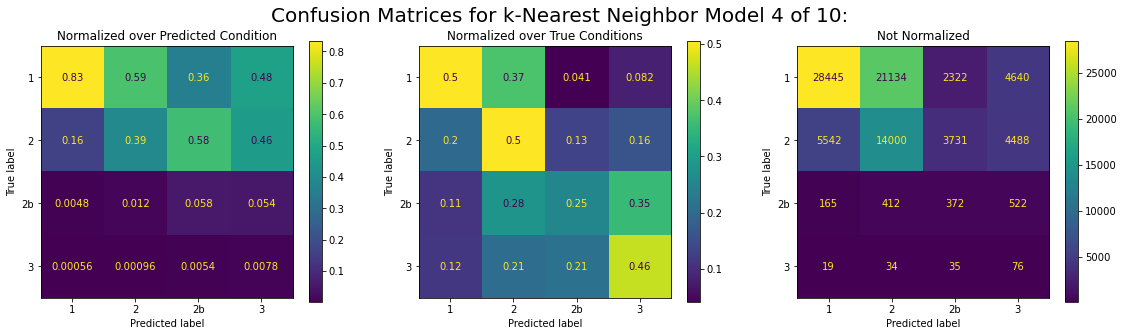

k-Nearest Neighbor Model 5 of 10:

              precision    recall  f1-score   support

           1   0.786982  0.596169  0.678414     56541
           2   0.404897  0.399661  0.402262     27761
          2b   0.067308  0.233175  0.104462      1471
           3   0.007636  0.493902  0.015040       164

    accuracy                       0.526281     85937
   macro avg   0.316706  0.430727  0.300045     85937
weighted avg   0.649748  0.526281  0.578116     85937



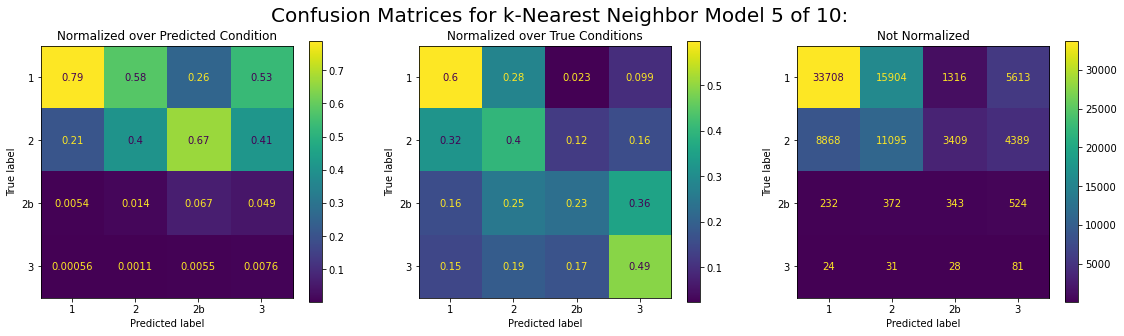

k-Nearest Neighbor Model 6 of 10:

              precision    recall  f1-score   support

           1   0.818523  0.516439  0.633303     56541
           2   0.393621  0.481035  0.432960     27761
          2b   0.058420  0.225697  0.092815      1471
           3   0.007791  0.506098  0.015345       164

    accuracy                       0.500006     85937
   macro avg   0.319589  0.432317  0.293606     85937
weighted avg   0.666705  0.500006  0.558153     85937



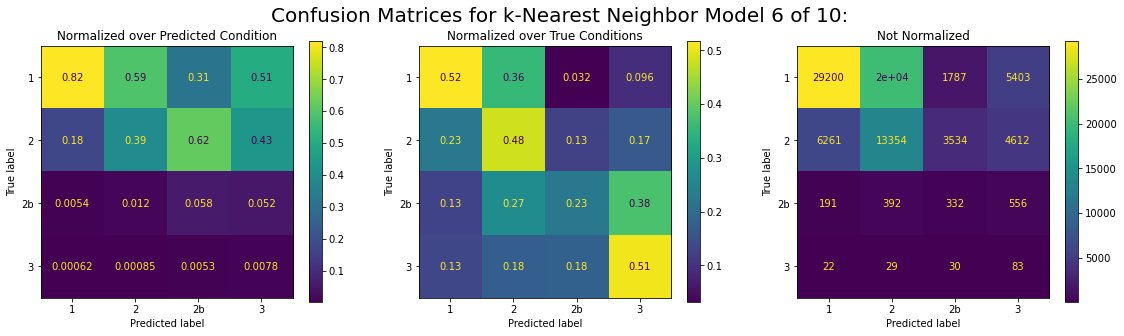

k-Nearest Neighbor Model 7 of 10:

              precision    recall  f1-score   support

           1   0.820211  0.534869  0.647497     56541
           2   0.409115  0.492129  0.446799     27761
          2b   0.060637  0.203263  0.093408      1471
           3   0.007169  0.469512  0.014122       164

    accuracy                       0.515261     85937
   macro avg   0.324283  0.424943  0.300457     85937
weighted avg   0.672858  0.515261  0.571971     85937



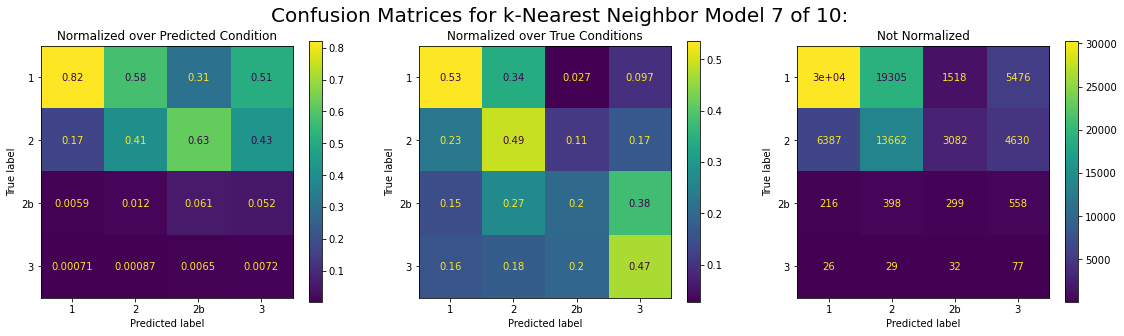

k-Nearest Neighbor Model 8 of 10:

              precision    recall  f1-score   support

           1   0.822155  0.531614  0.645707     56541
           2   0.407353  0.429055  0.417922     27761
          2b   0.043772  0.264446  0.075111      1471
           3   0.007556  0.518293  0.014894       164

    accuracy                       0.493885     85937
   macro avg   0.320209  0.435852  0.288409     85937
weighted avg   0.673280  0.493885  0.561153     85937



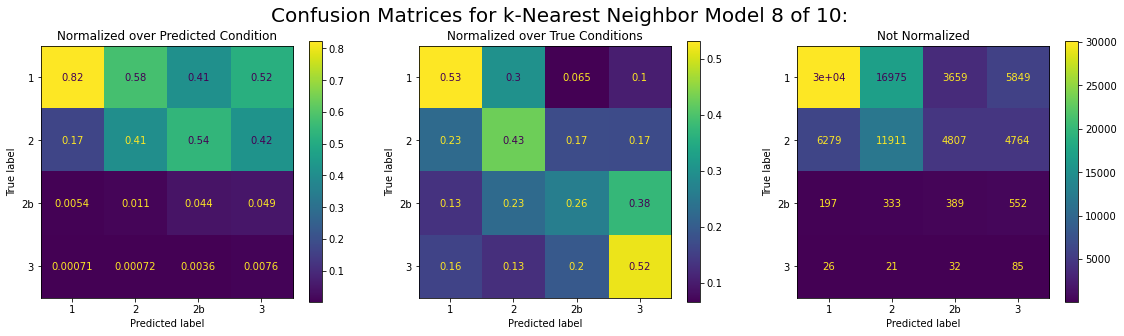

k-Nearest Neighbor Model 9 of 10:

              precision    recall  f1-score   support

           1   0.818483  0.519729  0.635758     56541
           2   0.403470  0.398689  0.401065     27761
          2b   0.037817  0.288239  0.066861      1471
           3   0.006848  0.475610  0.013502       164

    accuracy                       0.476582     85937
   macro avg   0.316655  0.420567  0.279297     85937
weighted avg   0.669506  0.476582  0.549018     85937



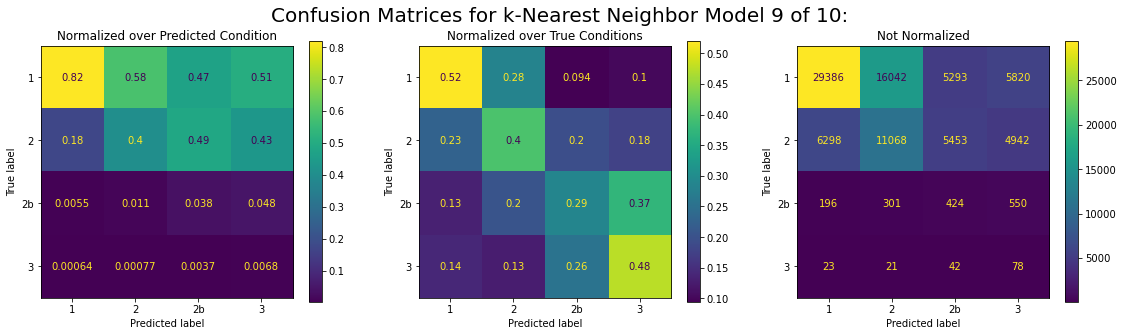

k-Nearest Neighbor Model 10 of 10:

              precision    recall  f1-score   support

           1   0.834010  0.508392  0.631710     56541
           2   0.400803  0.463636  0.429936     27761
          2b   0.046038  0.270564  0.078687      1471
           3   0.007281  0.475610  0.014342       164

    accuracy                       0.489801     85937
   macro avg   0.322033  0.429551  0.288669     85937
weighted avg   0.679002  0.489801  0.555885     85937



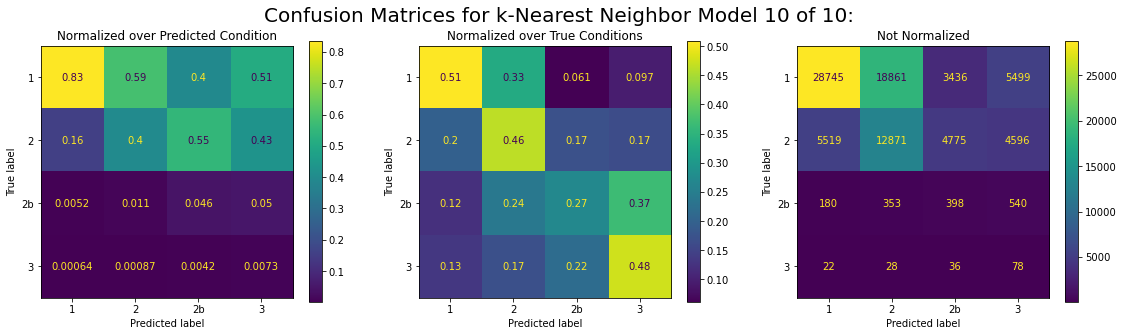

In [74]:
# For each k-Nearest Neighbor classifier in the cross-validation, print the macro recall, score report, and confusion matrices.
number_of_models = len(k_neighbors_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, knn_clf in zip(range(len(k_neighbors_scores['estimator'])), k_neighbors_scores['estimator']):
    y_test_predicted = knn_clf.predict(X_test)
    print('k-Nearest Neighbor Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for k-Nearest Neighbor Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1, 3, 1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1, 3, 2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1, 3, 3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)

    plt.show()

In [75]:
print('All reports and graphics generated in %f seconds.' % (elapsed_time(t0)))

All reports and graphics generated in 3490.517947 seconds.


In [76]:
print_elapsed_time(notebook_start_time)

Elapsed time is 3906.52619620692 seconds.
